In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# COMPLETE DATA GENERATION FUNCTION
def generate_city_transport_data(n_areas=200):
    """
    Generate synthetic data representing different city areas with transport characteristics
    """
    np.random.seed(42)
    
    data = {
        'area_id': range(n_areas),
        'population_density': np.random.normal(5000, 2000, n_areas),
        'avg_income': np.random.normal(50000, 15000, n_areas),
        'distance_to_center': np.random.exponential(5, n_areas),
        'public_transport_usage': np.random.normal(35, 15, n_areas),
        'car_ownership': np.random.normal(60, 20, n_areas),
        'employment_rate': np.random.normal(75, 10, n_areas),
        'student_population': np.random.normal(20, 8, n_areas),
        'elderly_population': np.random.normal(15, 5, n_areas)
    }
    
    df = pd.DataFrame(data)
    
    # Ensure realistic bounds
    df['population_density'] = df['population_density'].clip(1000, 15000)
    df['avg_income'] = df['avg_income'].clip(20000, 100000)
    df['public_transport_usage'] = df['public_transport_usage'].clip(5, 80)
    df['car_ownership'] = df['car_ownership'].clip(20, 95)
    df['employment_rate'] = df['employment_rate'].clip(50, 95)
    df['student_population'] = df['student_population'].clip(5, 40)
    df['elderly_population'] = df['elderly_population'].clip(5, 30)
    
    # Generate travel demand based on features
    df['travel_demand'] = (
        df['population_density'] * 0.3 +
        df['employment_rate'] * 2 +
        df['student_population'] * 1.5 +
        df['elderly_population'] * 1.2 +
        np.random.normal(0, 10, n_areas)
    )
    
    return df

# Generate the data
city_data = generate_city_transport_data()
print(f"Generated data with {len(city_data)} areas")

# NOW RUN THE BASIC DATA INSPECTION
print("First 5 rows:")
print(city_data.head())

print("\nData types and missing values:")
print(city_data.info())

print("\nStatistical summary:")
print(city_data.describe())

Generated data with 200 areas
First 5 rows:
   area_id  population_density    avg_income  distance_to_center  \
0        0         5993.428306  55366.810405            2.679175   
1        1         4723.471398  58411.767896            1.596944   
2        2         6295.377076  66245.768648            0.290135   
3        3         8046.059713  65807.030781           10.002131   
4        4         4531.693251  29334.959481            8.380587   

   public_transport_usage  car_ownership  employment_rate  student_population  \
0               40.064040      41.012022        74.178488           33.136121   
1               28.821846      95.000000        86.172958           28.078537   
2               27.685907      69.866358        78.427253           14.494797   
3               28.511627      63.696722        79.567532           38.019486   
4               40.916782      42.832844        80.697673           27.854124   

   elderly_population  travel_demand  
0           12.117448

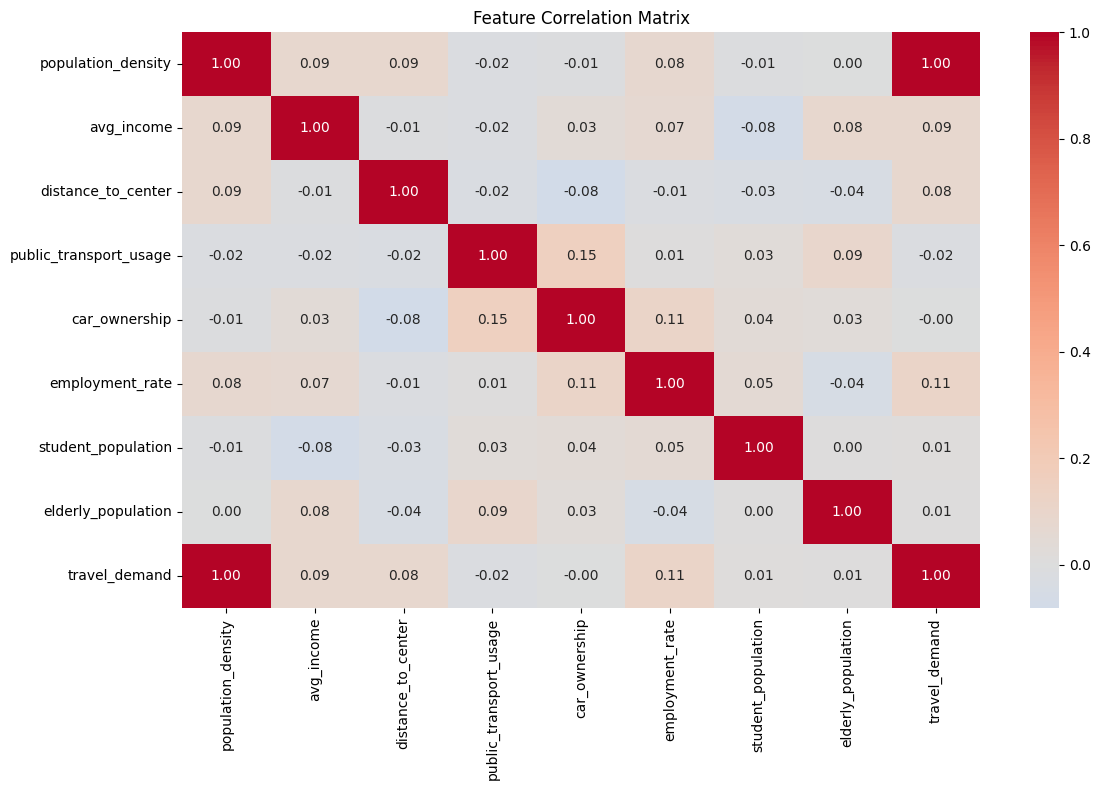

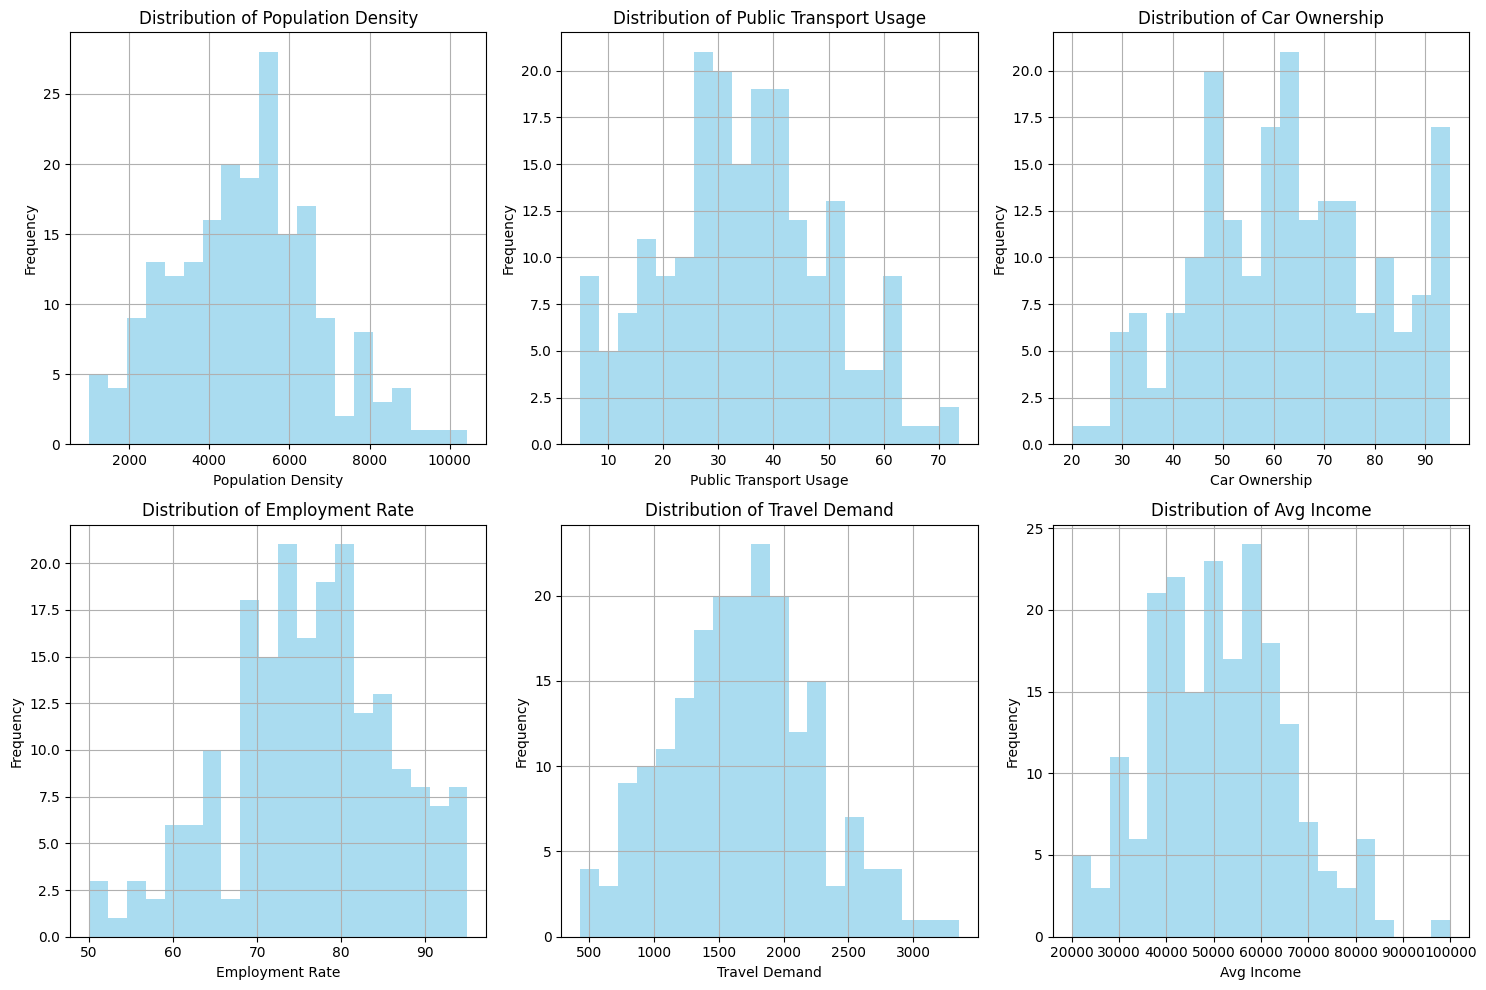

In [5]:
# Correlation analysis
plt.figure(figsize=(12, 8))
correlation_matrix = city_data.drop('area_id', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Distribution of key features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
features_to_plot = ['population_density', 'public_transport_usage', 'car_ownership', 
                   'employment_rate', 'travel_demand', 'avg_income']

for i, feature in enumerate(features_to_plot):
    ax = axes[i//3, i%3]
    city_data[feature].hist(bins=20, ax=ax, alpha=0.7, color='skyblue')
    ax.set_title(f'Distribution of {feature.replace("_", " ").title()}')
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Features standardized for clustering
Shape of scaled data: (200, 8)


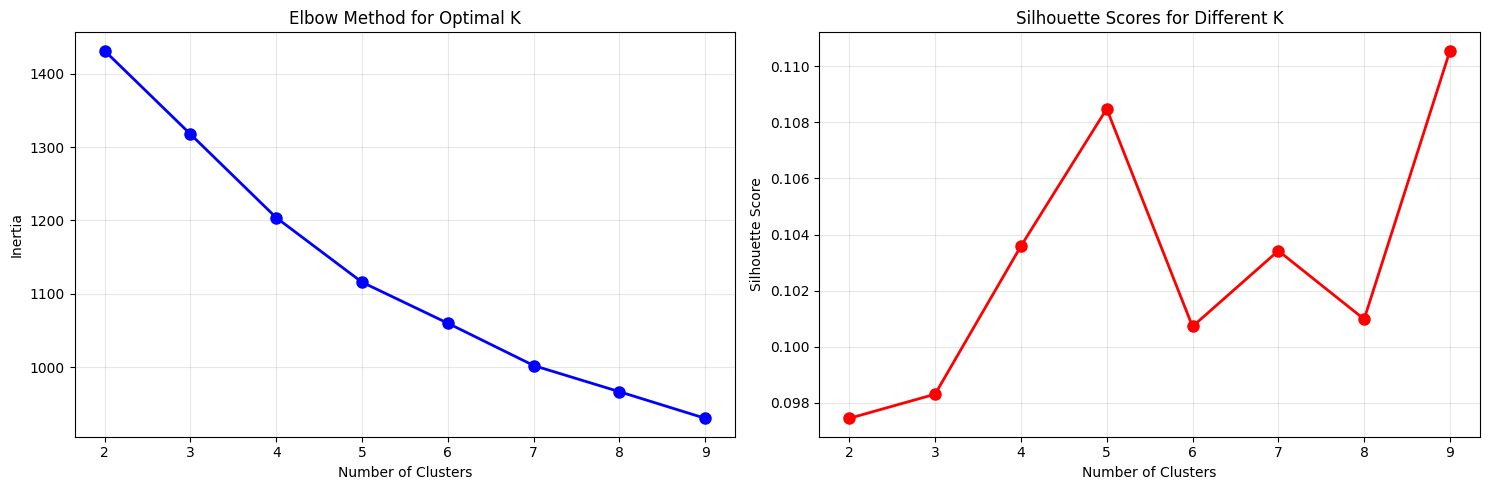

Optimal number of clusters: 9
Best silhouette score: 0.111

Cluster Profiles (Average Values):
         population_density  avg_income  distance_to_center  \
cluster                                                       
0                   6616.71    50224.34                2.44   
1                   4338.14    56627.34                5.11   
2                   5580.01    75024.87                4.31   
3                   5447.38    55649.81                4.18   
4                   5558.14    40048.24                2.51   
5                   6650.45    48378.66               22.62   
6                   4844.17    54563.01                3.18   
7                   3490.60    33082.66                3.46   
8                   2980.14    46685.65                5.62   

         public_transport_usage  car_ownership  employment_rate  \
cluster                                                           
0                         24.86          68.93            80.27   
1         

In [6]:
# Prepare features for clustering
features_for_clustering = [
    'population_density', 'avg_income', 'distance_to_center',
    'public_transport_usage', 'car_ownership', 'employment_rate',
    'student_population', 'elderly_population'
]

X = city_data[features_for_clustering]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features standardized for clustering")
print(f"Shape of scaled data: {X_scaled.shape}")

# Determine optimal number of clusters
inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow curve
ax1.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal K')
ax1.grid(True, alpha=0.3)

# Silhouette scores
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Scores for Different K')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Choose optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores):.3f}")

# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
city_data['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze cluster characteristics
cluster_profiles = city_data.groupby('cluster')[features_for_clustering + ['travel_demand']].mean()
print("\nCluster Profiles (Average Values):")
print(cluster_profiles.round(2))

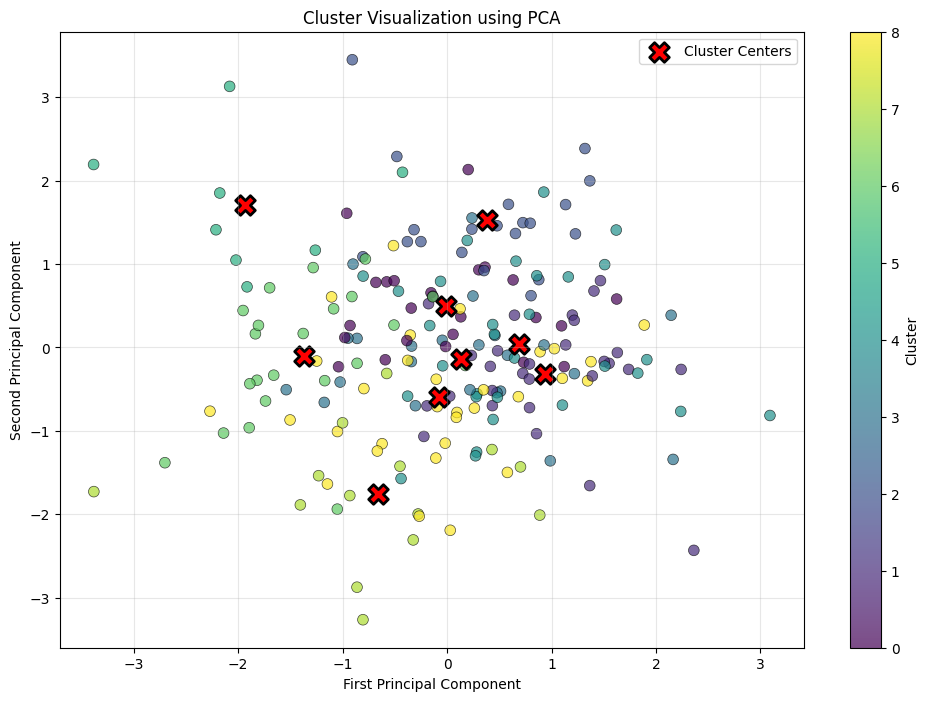

PCA Explained Variance: 30.51%


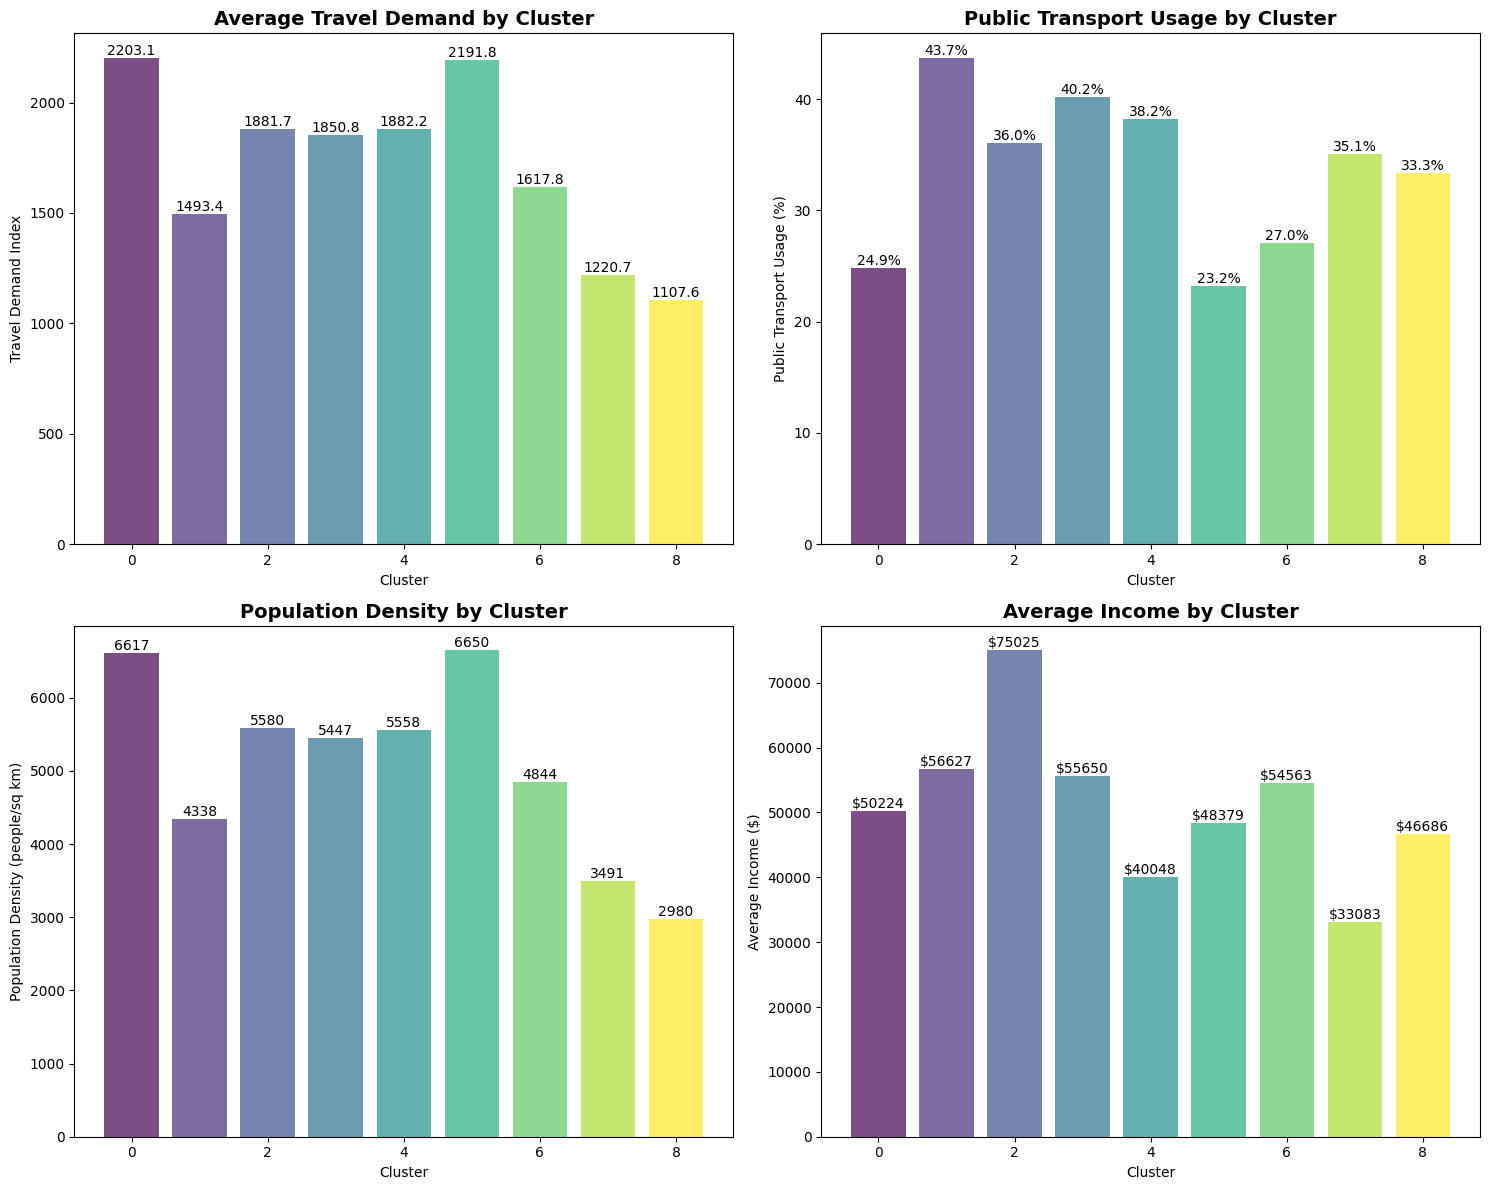


Cluster Sizes:
Cluster 0: 24 areas (12.0%)
Cluster 1: 28 areas (14.0%)
Cluster 2: 20 areas (10.0%)
Cluster 3: 23 areas (11.5%)
Cluster 4: 30 areas (15.0%)
Cluster 5: 8 areas (4.0%)
Cluster 6: 22 areas (11.0%)
Cluster 7: 14 areas (7.0%)
Cluster 8: 31 areas (15.5%)


In [7]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=city_data['cluster'], 
                     cmap='viridis', alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Cluster Visualization using PCA')
plt.grid(True, alpha=0.3)

# Add cluster centers in PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=200, 
           label='Cluster Centers', edgecolors='black', linewidth=2)
plt.legend()
plt.show()

print(f"PCA Explained Variance: {pca.explained_variance_ratio_.sum():.2%}")

# Create detailed cluster profile visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Prepare cluster summary
cluster_agg = city_data.groupby('cluster').agg({
    'travel_demand': 'mean',
    'public_transport_usage': 'mean',
    'population_density': 'mean',
    'avg_income': 'mean'
}).reset_index()

colors = plt.cm.viridis(np.linspace(0, 1, optimal_k))

# Plot 1: Travel demand by cluster
axes[0, 0].bar(cluster_agg['cluster'], cluster_agg['travel_demand'], color=colors, alpha=0.7)
axes[0, 0].set_title('Average Travel Demand by Cluster', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Travel Demand Index')
for i, v in enumerate(cluster_agg['travel_demand']):
    axes[0, 0].text(i, v, f'{v:.1f}', ha='center', va='bottom')

# Plot 2: Public transport usage by cluster
axes[0, 1].bar(cluster_agg['cluster'], cluster_agg['public_transport_usage'], color=colors, alpha=0.7)
axes[0, 1].set_title('Public Transport Usage by Cluster', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Public Transport Usage (%)')
for i, v in enumerate(cluster_agg['public_transport_usage']):
    axes[0, 1].text(i, v, f'{v:.1f}%', ha='center', va='bottom')

# Plot 3: Population density by cluster
axes[1, 0].bar(cluster_agg['cluster'], cluster_agg['population_density'], color=colors, alpha=0.7)
axes[1, 0].set_title('Population Density by Cluster', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Population Density (people/sq km)')
for i, v in enumerate(cluster_agg['population_density']):
    axes[1, 0].text(i, v, f'{v:.0f}', ha='center', va='bottom')

# Plot 4: Income distribution by cluster
axes[1, 1].bar(cluster_agg['cluster'], cluster_agg['avg_income'], color=colors, alpha=0.7)
axes[1, 1].set_title('Average Income by Cluster', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Average Income ($)')
for i, v in enumerate(cluster_agg['avg_income']):
    axes[1, 1].text(i, v, f'${v:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Show cluster sizes
cluster_sizes = city_data['cluster'].value_counts().sort_index()
print("\nCluster Sizes:")
for cluster_id, size in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {size} areas ({size/len(city_data)*100:.1f}%)")

Training set: 160 samples
Test set: 40 samples

REGRESSION MODEL PERFORMANCE
Training MAE: 7.60
Test MAE: 7.59
Training R²: 0.9997
Test R²: 0.9997

FEATURE IMPORTANCE (Absolute Coefficients):
                  feature  importance
5         employment_rate    2.119480
6      student_population    1.622235
7      elderly_population    1.066711
0      population_density    0.300765
8                 cluster    0.298329
2      distance_to_center    0.116355
4           car_ownership    0.057306
3  public_transport_usage    0.006066
1              avg_income    0.000003


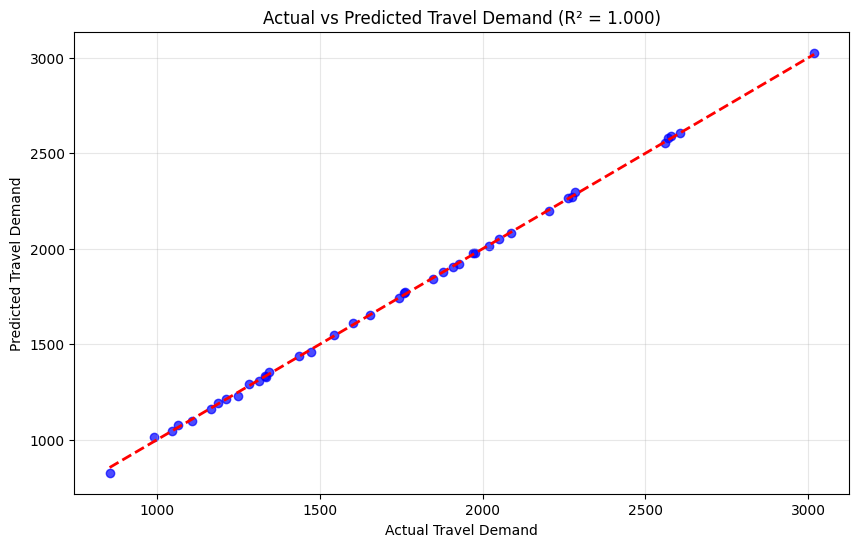

In [8]:
# Build regression model to predict travel demand
prediction_features = [
    'population_density', 'avg_income', 'distance_to_center',
    'public_transport_usage', 'car_ownership', 'employment_rate',
    'student_population', 'elderly_population', 'cluster'
]

X_pred = city_data[prediction_features]
y_pred = city_data['travel_demand']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_pred, y_pred, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Make predictions
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)

# Evaluate model
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("\n" + "="*50)
print("REGRESSION MODEL PERFORMANCE")
print("="*50)
print(f"Training MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': prediction_features,
    'importance': abs(regressor.coef_)
}).sort_values('importance', ascending=False)

print("\nFEATURE IMPORTANCE (Absolute Coefficients):")
print(feature_importance)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Travel Demand')
plt.ylabel('Predicted Travel Demand')
plt.title(f'Actual vs Predicted Travel Demand (R² = {test_r2:.3f})')
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# Generate route optimization recommendations based on clusters
def generate_recommendations(cluster_data):
    recommendations = {}
    
    for cluster_id in cluster_data['cluster'].unique():
        cluster_df = cluster_data[cluster_data['cluster'] == cluster_id]
        cluster_info = cluster_df.mean()
        
        rec = {
            'cluster_id': cluster_id,
            'area_type': '',
            'characteristics': '',
            'recommended_routes': [],
            'frequency_recommendation': '',
            'accessibility_focus': '',
            'estimated_coverage': len(cluster_df)
        }
        
        # Determine area type based on characteristics
        pop_density = cluster_info['population_density']
        pt_usage = cluster_info['public_transport_usage']
        income = cluster_info['avg_income']
        
        if pop_density > 6000:
            rec['area_type'] = 'High Density Urban'
            rec['characteristics'] = f'Dense urban core ({(pop_density/1000):.1f}k people/sq km)'
            rec['recommended_routes'] = [
                'High-frequency metro lines (5-10 min intervals)',
                'Express bus routes to city center',
                '24-hour night bus services',
                'Dedicated bus rapid transit (BRT) corridors'
            ]
            rec['frequency_recommendation'] = 'Peak: 5-7 min, Off-peak: 10-15 min'
            rec['accessibility_focus'] = 'Multi-modal integration, Last-mile connectivity, Real-time tracking'
            
        elif pop_density > 4000:
            rec['area_type'] = 'Medium Density Suburban'
            rec['characteristics'] = f'Suburban areas ({(pop_density/1000):.1f}k people/sq km)'
            rec['recommended_routes'] = [
                'Feeder buses to transit hubs',
                'Circular local routes connecting residential areas',
                'Commuter rail with park-and-ride',
                'Cross-town direct routes'
            ]
            rec['frequency_recommendation'] = 'Peak: 10-12 min, Off-peak: 20-25 min'
            rec['accessibility_focus'] = 'Park-and-ride facilities, Bike sharing integration, Timed transfers'
            
        else:
            rec['area_type'] = 'Low Density/Rural'
            rec['characteristics'] = f'Rural/outlying areas ({(pop_density/1000):.1f}k people/sq km)'
            rec['recommended_routes'] = [
                'On-demand flexible services',
                'Fixed-route with flexible scheduling',
                'Community shuttle services',
                'Inter-village connector routes'
            ]
            rec['frequency_recommendation'] = 'Peak: 20-30 min, Off-peak: 45-60 min (or on-demand)'
            rec['accessibility_focus'] = 'Mobility as a Service, Community transport, Demand-responsive transit'
        
        # Special considerations based on demographics
        special_features = []
        if cluster_info['elderly_population'] > 20:
            special_features.append('high elderly population')
            rec['accessibility_focus'] += ', Senior-friendly vehicles with low floors'
        if cluster_info['student_population'] > 25:
            special_features.append('high student population')
            rec['accessibility_focus'] += ', University shuttle services, Student discounts'
        if cluster_info['avg_income'] < 40000:
            special_features.append('lower-income community')
            rec['accessibility_focus'] += ', Affordable fare structure, Subsidized passes'
            
        if special_features:
            rec['characteristics'] += f" | Features: {', '.join(special_features)}"
            
        recommendations[cluster_id] = rec
    
    return recommendations

# Generate and display recommendations
print("GENERATING ROUTE OPTIMIZATION RECOMMENDATIONS...")
recommendations = generate_recommendations(city_data)

print("\n" + "="*70)
print("ROUTE OPTIMIZATION RECOMMENDATIONS BY CLUSTER")
print("="*70)

for cluster_id in sorted(recommendations.keys()):
    rec = recommendations[cluster_id]
    print(f"\n🚏 CLUSTER {cluster_id} - {rec['area_type']}")
    print(f"   📊 Characteristics: {rec['characteristics']}")
    print(f"   📍 Coverage: {rec['estimated_coverage']} areas")
    print(f"   🚌 Recommended Routes:")
    for i, route in enumerate(rec['recommended_routes'], 1):
        print(f"      {i}. {route}")
    print(f"   ⏰ Frequency: {rec['frequency_recommendation']}")
    print(f"   ♿ Accessibility: {rec['accessibility_focus']}")

GENERATING ROUTE OPTIMIZATION RECOMMENDATIONS...

ROUTE OPTIMIZATION RECOMMENDATIONS BY CLUSTER

🚏 CLUSTER 0 - High Density Urban
   📊 Characteristics: Dense urban core (6.6k people/sq km) | Features: high student population
   📍 Coverage: 24 areas
   🚌 Recommended Routes:
      1. High-frequency metro lines (5-10 min intervals)
      2. Express bus routes to city center
      3. 24-hour night bus services
      4. Dedicated bus rapid transit (BRT) corridors
   ⏰ Frequency: Peak: 5-7 min, Off-peak: 10-15 min
   ♿ Accessibility: Multi-modal integration, Last-mile connectivity, Real-time tracking, University shuttle services, Student discounts

🚏 CLUSTER 1 - Medium Density Suburban
   📊 Characteristics: Suburban areas (4.3k people/sq km)
   📍 Coverage: 28 areas
   🚌 Recommended Routes:
      1. Feeder buses to transit hubs
      2. Circular local routes connecting residential areas
      3. Commuter rail with park-and-ride
      4. Cross-town direct routes
   ⏰ Frequency: Peak: 10-12 min


CALCULATING ENVIRONMENTAL IMPACT...

ENVIRONMENTAL AND SOCIOECONOMIC IMPACT ASSESSMENT

🌍 CLUSTER 0 - High Density Urban
   👥 Population served: 158,801 people
   📊 Current PT usage: 24.9%
   🎯 Potential PT usage: 31.1% (+6.2%)
   🚗 Car usage reduction: 6.2%
   🌱 Annual CO₂ reduction: 3,849.3 tons
   ⛽ Annual fuel savings: 2,052,947 liters
   🚦 Congestion reduction: 5.0%

🌍 CLUSTER 1 - Medium Density Suburban
   👥 Population served: 121,467 people
   📊 Current PT usage: 43.7%
   🎯 Potential PT usage: 49.3% (+5.5%)
   🚗 Car usage reduction: 5.5%
   🌱 Annual CO₂ reduction: 2,626.7 tons
   ⛽ Annual fuel savings: 1,400,886 liters
   🚦 Congestion reduction: 4.4%

🌍 CLUSTER 2 - Medium Density Suburban
   👥 Population served: 111,600 people
   📊 Current PT usage: 36.0%
   🎯 Potential PT usage: 40.7% (+4.7%)
   🚗 Car usage reduction: 4.7%
   🌱 Annual CO₂ reduction: 2,059.0 tons
   ⛽ Annual fuel savings: 1,098,150 liters
   🚦 Congestion reduction: 3.8%

🌍 CLUSTER 3 - Medium Density Suburban
  

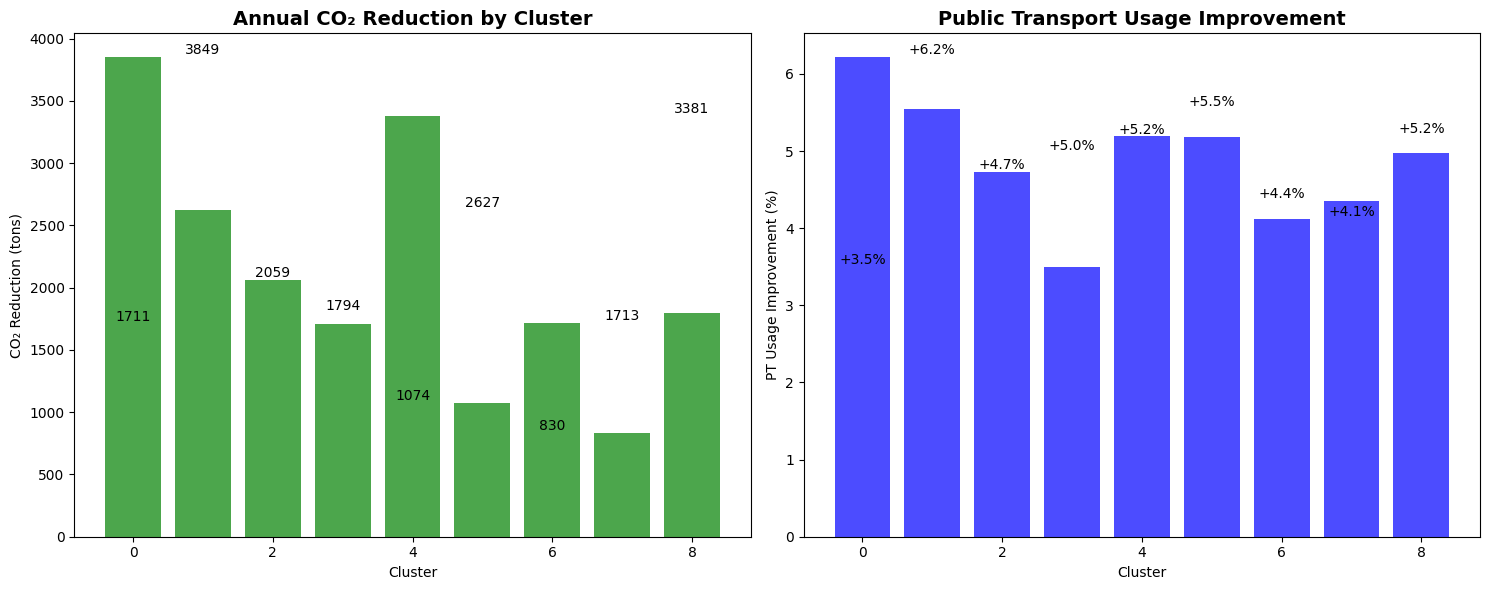

In [10]:
# Calculate potential environmental benefits
def calculate_environmental_impact(cluster_data, recommendations):
    impact_analysis = {}
    
    for cluster_id in cluster_data['cluster'].unique():
        cluster_areas = cluster_data[cluster_data['cluster'] == cluster_id]
        avg_pt_usage = cluster_areas['public_transport_usage'].mean()
        current_car_usage = cluster_areas['car_ownership'].mean()
        population = cluster_areas['population_density'].mean() * len(cluster_areas) / 1000  # approx population in thousands
        
        # Estimate improvement potential (assuming optimization increases PT usage)
        # More realistic: areas with lower current PT usage have higher improvement potential
        improvement_factor = (100 - avg_pt_usage) / 100
        potential_improvement = current_car_usage * 0.12 * improvement_factor
        new_pt_usage = avg_pt_usage + potential_improvement
        
        # Calculate CO2 reduction (assuming average car emits 0.2 kg CO2 per km)
        # and public transport emits 0.05 kg CO2 per passenger km
        daily_km_per_car = 25  # average daily commute distance
        cars_shifted = (potential_improvement / 100) * (population * 1000) * 0.4  # 40% of population are car owners
        
        co2_reduction_per_car_km = 0.2 - 0.05  # kg CO2 reduction per km shifted from car to PT
        daily_co2_reduction_kg = cars_shifted * daily_km_per_car * co2_reduction_per_car_km
        annual_co2_reduction_tons = (daily_co2_reduction_kg * 260) / 1000  # 260 working days
        
        # Additional benefits
        fuel_savings_liters = (cars_shifted * daily_km_per_car * 260 * 0.08)  # 8L/100km efficiency
        congestion_reduction = potential_improvement * 0.8  # arbitrary congestion index
        
        impact_analysis[cluster_id] = {
            'current_pt_usage': avg_pt_usage,
            'potential_pt_usage': new_pt_usage,
            'pt_usage_improvement': potential_improvement,
            'car_usage_reduction': potential_improvement,
            'annual_co2_reduction_tons': annual_co2_reduction_tons,
            'annual_fuel_savings_liters': fuel_savings_liters,
            'congestion_reduction_percent': congestion_reduction,
            'areas_affected': len(cluster_areas),
            'estimated_population_served': int(population * 1000)
        }
    
    return impact_analysis

# Calculate and display environmental impact
print("\nCALCULATING ENVIRONMENTAL IMPACT...")
environmental_impact = calculate_environmental_impact(city_data, recommendations)

print("\n" + "="*80)
print("ENVIRONMENTAL AND SOCIOECONOMIC IMPACT ASSESSMENT")
print("="*80)

total_co2_reduction = 0
total_fuel_savings = 0
total_population_served = 0

for cluster_id in sorted(environmental_impact.keys()):
    impact = environmental_impact[cluster_id]
    rec = recommendations[cluster_id]
    
    print(f"\n🌍 CLUSTER {cluster_id} - {rec['area_type']}")
    print(f"   👥 Population served: {impact['estimated_population_served']:,} people")
    print(f"   📊 Current PT usage: {impact['current_pt_usage']:.1f}%")
    print(f"   🎯 Potential PT usage: {impact['potential_pt_usage']:.1f}% (+{impact['pt_usage_improvement']:.1f}%)")
    print(f"   🚗 Car usage reduction: {impact['car_usage_reduction']:.1f}%")
    print(f"   🌱 Annual CO₂ reduction: {impact['annual_co2_reduction_tons']:,.1f} tons")
    print(f"   ⛽ Annual fuel savings: {impact['annual_fuel_savings_liters']:,.0f} liters")
    print(f"   🚦 Congestion reduction: {impact['congestion_reduction_percent']:.1f}%")
    
    total_co2_reduction += impact['annual_co2_reduction_tons']
    total_fuel_savings += impact['annual_fuel_savings_liters']
    total_population_served += impact['estimated_population_served']

# Final summary
print("\n" + "="*80)
print("OVERALL SUSTAINABILITY IMPACT SUMMARY")
print("="*80)
print(f"📈 Total Annual CO₂ Reduction: {total_co2_reduction:,.1f} tons")
print(f"💧 Equivalent to:")
print(f"   - Carbon sequestered by {total_co2_reduction * 50:,.0f} tree seedlings grown for 10 years")
print(f"   - Emissions from {total_co2_reduction / 2.3:,.0f} passenger vehicles driven for one year")
print(f"⛽ Total Annual Fuel Savings: {total_fuel_savings:,.0f} liters (${total_fuel_savings * 1.2:,.0f} at $1.2/L)")
print(f"👥 Total Population Served: {total_population_served:,} people")
print(f"🏙️  Total Areas Optimized: {len(city_data)} areas")

# Visualize environmental impact
impact_df = pd.DataFrame.from_dict(environmental_impact, orient='index')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# CO2 reduction by cluster
ax1.bar(impact_df.index, impact_df['annual_co2_reduction_tons'], color='green', alpha=0.7)
ax1.set_title('Annual CO₂ Reduction by Cluster', fontsize=14, fontweight='bold')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('CO₂ Reduction (tons)')
for i, v in enumerate(impact_df['annual_co2_reduction_tons']):
    ax1.text(i, v, f'{v:.0f}', ha='center', va='bottom')

# PT usage improvement
ax2.bar(impact_df.index, impact_df['pt_usage_improvement'], color='blue', alpha=0.7)
ax2.set_title('Public Transport Usage Improvement', fontsize=14, fontweight='bold')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('PT Usage Improvement (%)')
for i, v in enumerate(impact_df['pt_usage_improvement']):
    ax2.text(i, v, f'+{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


PROJECT COMPLETION SUMMARY
💾 All results saved to CSV files:
   - city_data_with_clusters.csv
   - cluster_profiles.csv
   - environmental_impact.csv
   - route_recommendations.csv

📊 MODEL PERFORMANCE SUMMARY:
   - Optimal clusters identified: 9
   - Clustering quality (silhouette score): 0.111
   - Travel demand prediction accuracy (R²): 1.000
   - Prediction error (MAE): 7.59

🌱 SUSTAINABILITY IMPACT:
   - Total annual CO₂ reduction: 19,038.4 tons
   - Total fuel savings: 10,153,808 liters annually
   - Population served: 984,927 people

🏙️  COVERAGE:
   - Areas analyzed: 200
   - Clusters created: 9
   - Route recommendations generated: 9

✅ PROJECT COMPLETED SUCCESSFULLY!
   The analysis provides data-driven insights for sustainable urban transport planning.
   Recommendations support SDG 11 targets for creating sustainable cities and communities.


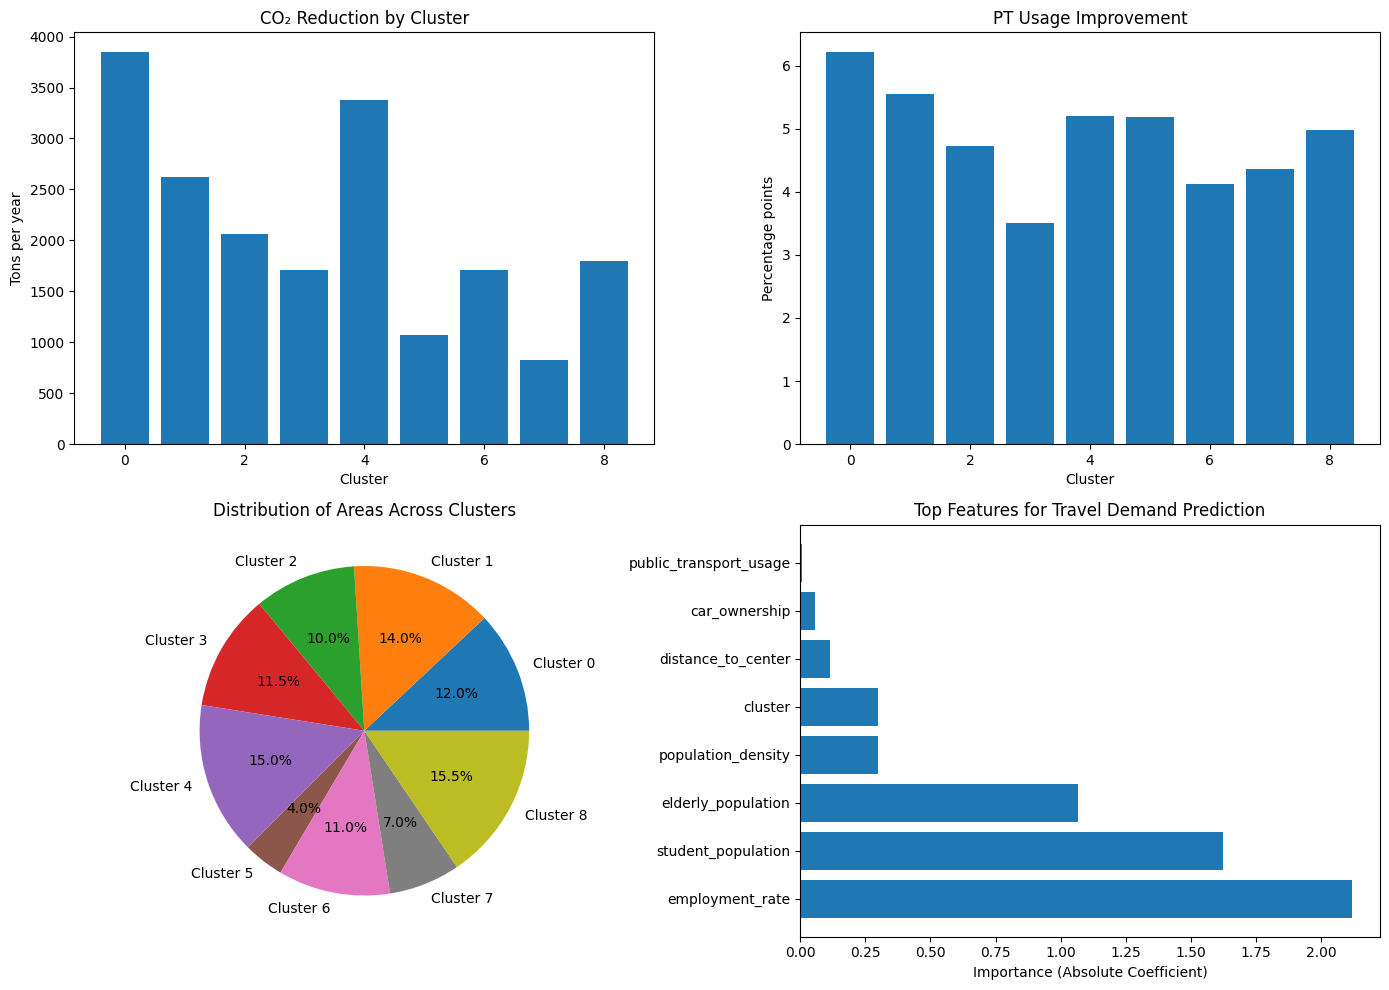

In [11]:
# Final results summary and saving
print("\n" + "="*80)
print("PROJECT COMPLETION SUMMARY")
print("="*80)

# Save all results
city_data.to_csv('city_data_with_clusters.csv', index=False)
cluster_profiles.to_csv('cluster_profiles.csv')
impact_df.to_csv('environmental_impact.csv')

# Convert recommendations to DataFrame and save
recommendations_df = pd.DataFrame.from_dict(recommendations, orient='index')
recommendations_df.to_csv('route_recommendations.csv')

print("💾 All results saved to CSV files:")
print("   - city_data_with_clusters.csv")
print("   - cluster_profiles.csv") 
print("   - environmental_impact.csv")
print("   - route_recommendations.csv")

# Final performance metrics
print(f"\n📊 MODEL PERFORMANCE SUMMARY:")
print(f"   - Optimal clusters identified: {optimal_k}")
print(f"   - Clustering quality (silhouette score): {max(silhouette_scores):.3f}")
print(f"   - Travel demand prediction accuracy (R²): {test_r2:.3f}")
print(f"   - Prediction error (MAE): {test_mae:.2f}")

print(f"\n🌱 SUSTAINABILITY IMPACT:")
print(f"   - Total annual CO₂ reduction: {total_co2_reduction:,.1f} tons")
print(f"   - Total fuel savings: {total_fuel_savings:,.0f} liters annually")
print(f"   - Population served: {total_population_served:,} people")

print(f"\n🏙️  COVERAGE:")
print(f"   - Areas analyzed: {len(city_data)}")
print(f"   - Clusters created: {optimal_k}")
print(f"   - Route recommendations generated: {len(recommendations)}")

print("\n✅ PROJECT COMPLETED SUCCESSFULLY!")
print("   The analysis provides data-driven insights for sustainable urban transport planning.")
print("   Recommendations support SDG 11 targets for creating sustainable cities and communities.")

# Create one final comprehensive visualization
plt.figure(figsize=(14, 10))

# Create a 2x2 summary dashboard
plt.subplot(2, 2, 1)
plt.bar(range(optimal_k), [environmental_impact[k]['annual_co2_reduction_tons'] for k in range(optimal_k)])
plt.title('CO₂ Reduction by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Tons per year')

plt.subplot(2, 2, 2)
plt.bar(range(optimal_k), [environmental_impact[k]['pt_usage_improvement'] for k in range(optimal_k)])
plt.title('PT Usage Improvement')
plt.xlabel('Cluster')
plt.ylabel('Percentage points')

plt.subplot(2, 2, 3)
cluster_sizes = [len(city_data[city_data['cluster'] == k]) for k in range(optimal_k)]
plt.pie(cluster_sizes, labels=[f'Cluster {k}' for k in range(optimal_k)], autopct='%1.1f%%')
plt.title('Distribution of Areas Across Clusters')

plt.subplot(2, 2, 4)
importance_plot = feature_importance.head(8)  # Top 8 features
plt.barh(importance_plot['feature'], importance_plot['importance'])
plt.title('Top Features for Travel Demand Prediction')
plt.xlabel('Importance (Absolute Coefficient)')

plt.tight_layout()
plt.show()